# Numerical Methods for the GS model

We implemented 4 numerical methods to compute the solution for the **Gray Scott (GS)** model:

$$\frac{\partial u}{\partial t} = D_u (\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}) -uv^2 + f(1-u)$$

$$\frac{\partial v}{\partial t} = D_v (\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}) +uv^2 - (k+f)v$$

        

- Forward Euler Method

- Backward Euler Method

- Crank Nicolson Method

- Alternating Direction Implicit Method

For each method, we 

- computed the **evolution of the pattern** over time and visualized these patterns using 2D contour plot,

- saved the evolution of the pattern matrix's **mean deducted Frobenius norm** to gain an intuitive sense of the onset time of a stable pattern,

- and recoreded the **runtime** using each method.

## Experiments Parameters Setup

```python
Ny, Nx = 64, 64 # length of each side of the entire grid
h = 2 # space step size, same in x and y direction
N = Nx * Ny # 1D length of the entire grid

Du = 1.0 # diffusion rate of u
Dv = 0.5 # diffusion rate of v
ff = 0.055 # feed rate, same as 'f' in the model PDE equation
kk = 0.062 # kill rate, same as 'k' in the model PDE equation

dt = 0.5 # time step size for forwared euler
dt = 1 # time step size for backward euler and CN
dt = 1.5 # time step size for ADI
end_t = 10000 # end time
time_steps = int(end_t / dt) # number of time steps of the entire evolution

U_init[:, :] = 1 # initial condition for u: all 1
V_init[24:40, 24:40] = 1 # initial condition for v: a centered cluster of 1's
```

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Forward Euler Method

dt = 0.5, time_steps = 20000
elapsed_clock_time = 8.467026948928833


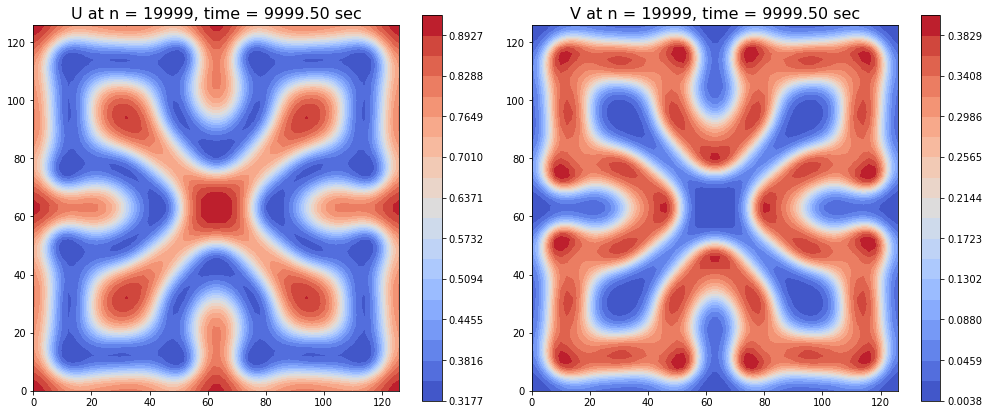

In [2]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 0.5
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))

# Start timer
start = time.time()

# Forward Euler
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U[i - 1]-np.mean(U[i - 1])), ord='fro')
    V_norm_arr[i-1] = np.linalg.norm((V[i - 1]-np.mean(V[i - 1])), ord='fro')
    time_range[i-1] = (i-1) * dt
    
    U[i] = Du * c * my_laplacian(U[i - 1])
    V[i] = Dv * c * my_laplacian(V[i - 1])

    U[i] += -dt * np.multiply(U[i - 1], np.square(V[i - 1])) \
        + dt * ff * (1 - U[i - 1]) + U[i - 1]
    V[i] += dt * np.multiply(U[i - 1], np.square(V[i - 1])) \
        - dt * (kk + ff) * V[i - 1] + V[i - 1]

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U[-1]-np.mean(U[-1])), ord='fro')
V_norm_arr[-1] = np.linalg.norm((V[-1]-np.mean(V[-1])), ord='fro')
time_range[-1] = (time_steps-1) * dt

plot_pattern(U, V, time_steps - 1, time_steps - 1, h, dt, filled=True)

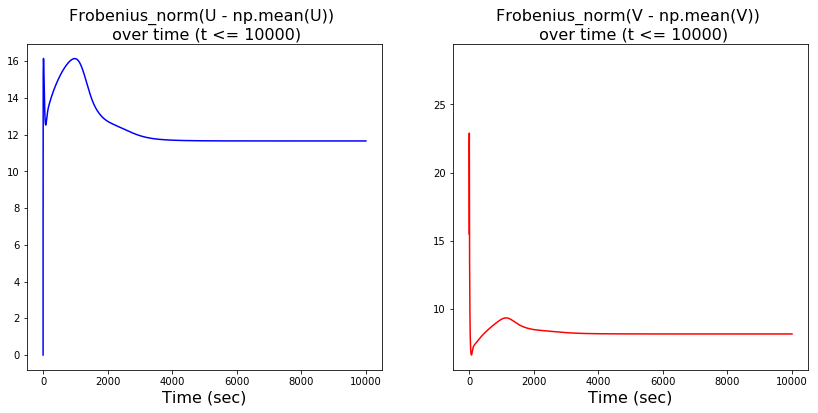

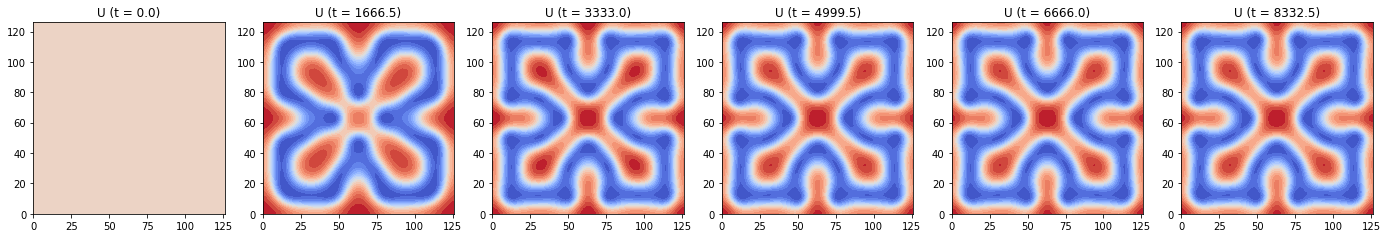

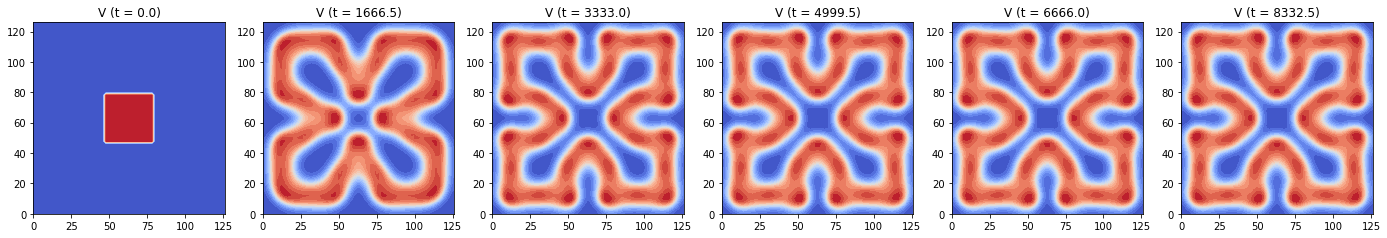

In [3]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

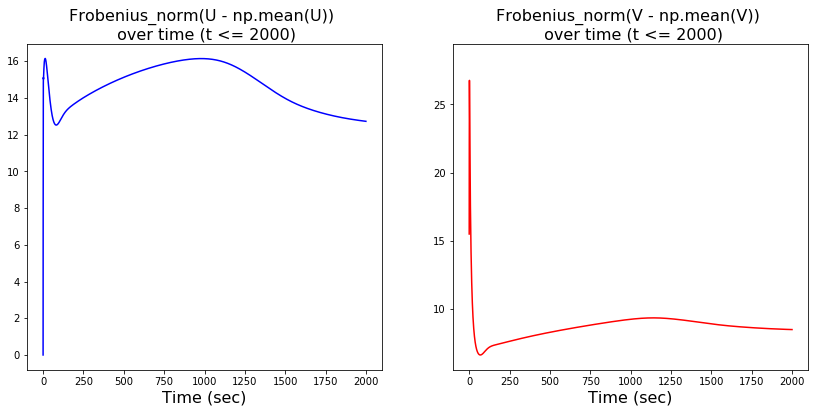

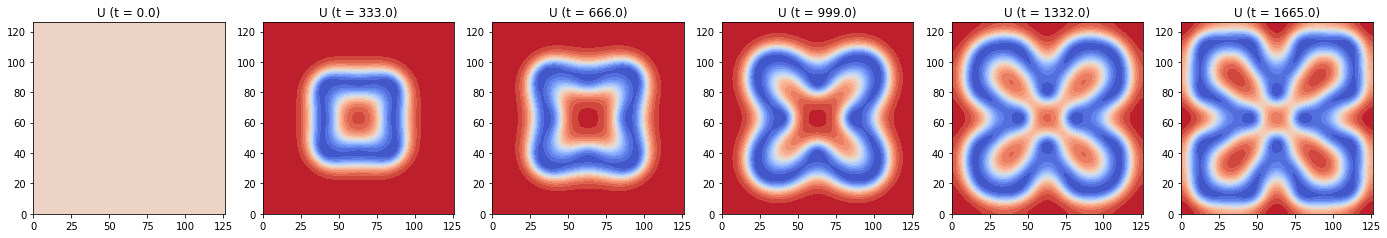

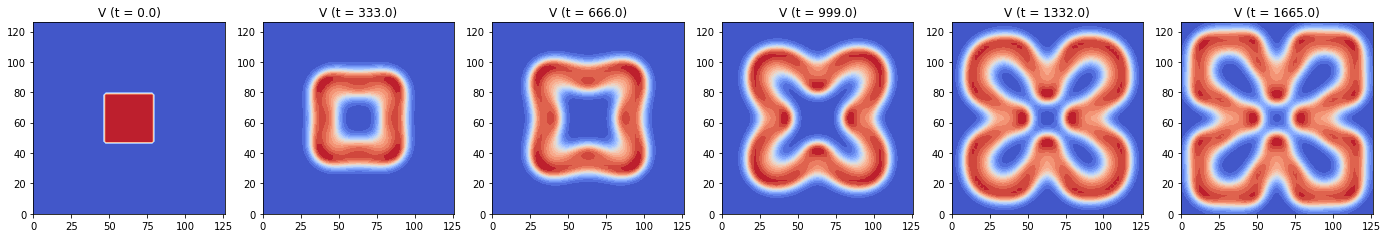

In [4]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 5, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=5, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=5, Nout=6)

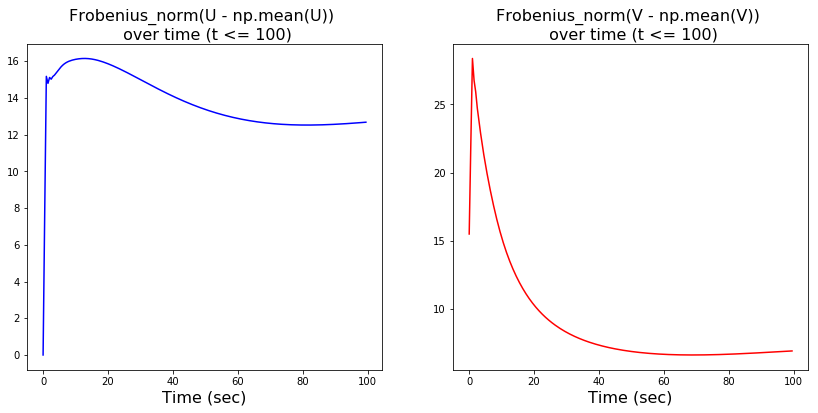

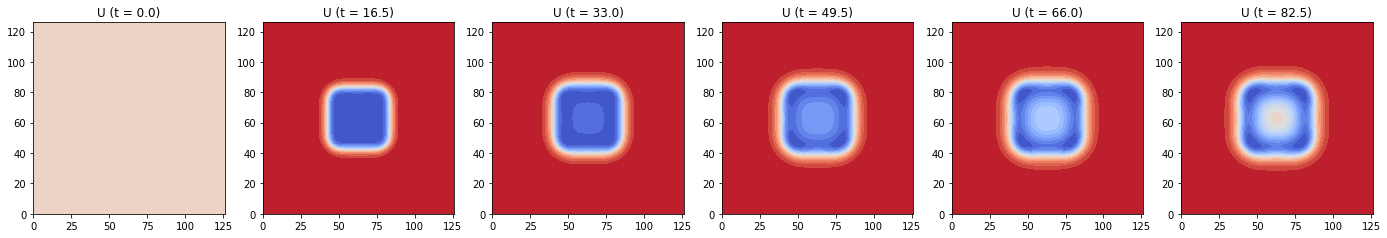

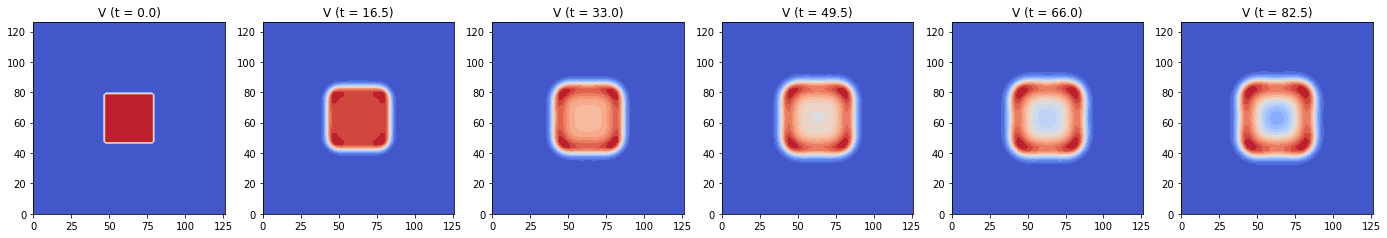

In [5]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 100, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=100, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=100, Nout=6)

## Backward Euler Method

dt = 1, time_steps = 10000
elapsed_clock_time = 41.289620876312256


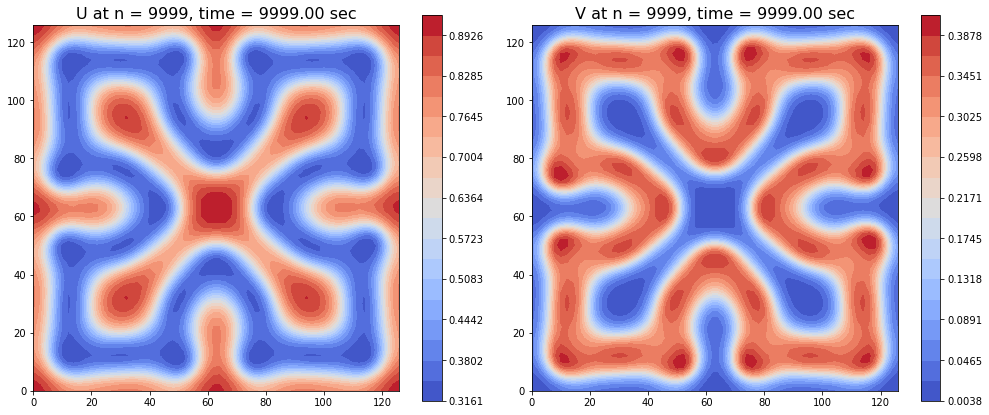

In [6]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Construct the transform matrix of U and V
# L = Laplace_matrix(Ny, Nx)
L = Laplace_matrix_sparse(Ny, Nx)
Tu = sparse.eye(N) - Du * c * L
Tv = sparse.eye(N) - Dv * c * L

# Factorize Tu, Tv
solve_Tu = linalg.factorized(Tu.tocsc())
solve_Tv = linalg.factorized(Tv.tocsc())

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))

# Start timer
start = time.time()

# Backward Euler
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U1d[i - 1]-np.mean(U1d[i - 1])))
    V_norm_arr[i-1] = np.linalg.norm((V1d[i - 1]-np.mean(V1d[i - 1])))
    time_range[i-1] = (i-1) * dt
    
    bU = np.multiply((1 - dt * np.square(V1d[i - 1]) - dt * ff), U1d[i - 1]) + dt * ff
    U1d[i] = solve_Tu(bU)

    bV = (1 - dt * kk - dt * ff) * V1d[i - 1] + dt * np.multiply(U1d[i - 1], np.square(V1d[i - 1]))
    V1d[i] = solve_Tv(bV)

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U1d[-1]-np.mean(U1d[-1])))
V_norm_arr[-1] = np.linalg.norm((V1d[-1]-np.mean(V1d[-1])))
time_range[-1] = (time_steps-1) * dt

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

plot_pattern(U2d, V2d, time_steps-1, time_steps-1, h, dt, filled=True)

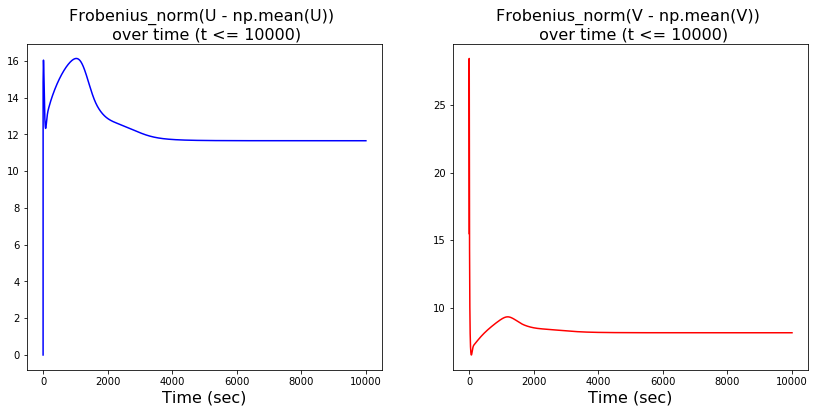

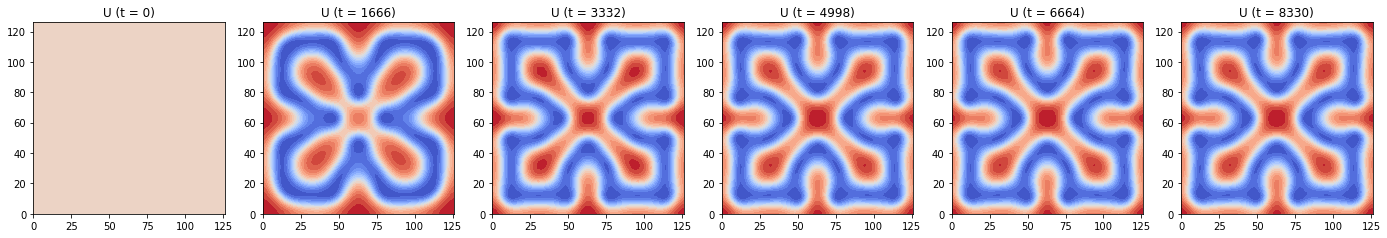

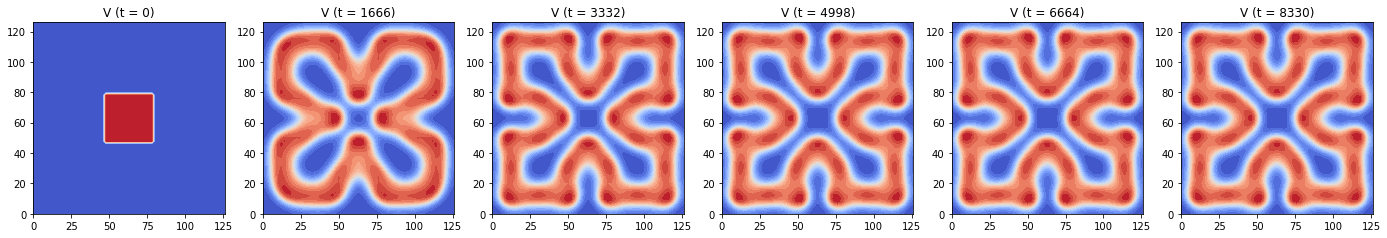

In [7]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=1, Nout=6)

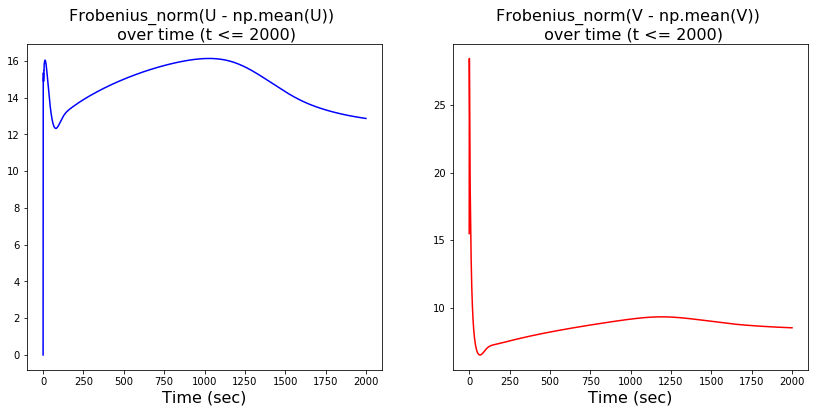

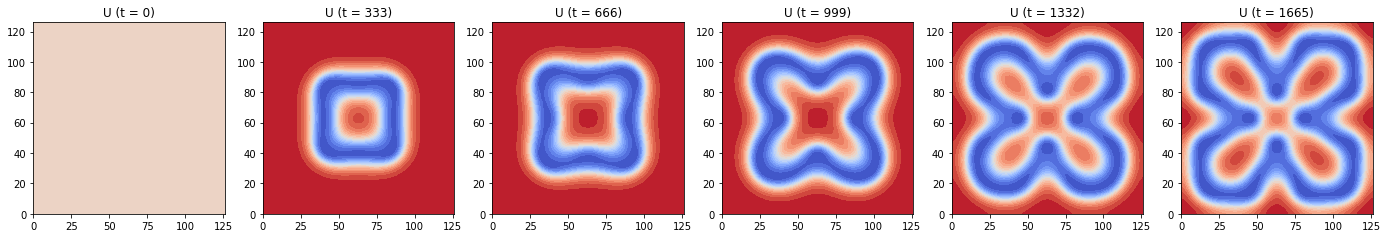

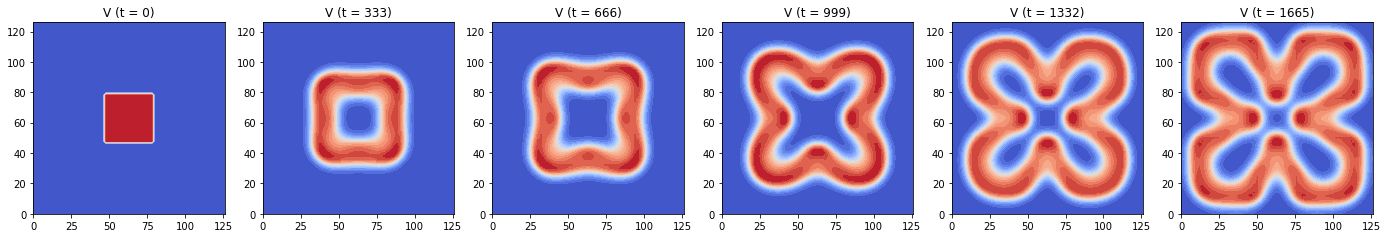

In [8]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 5, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=5, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=5, Nout=6)

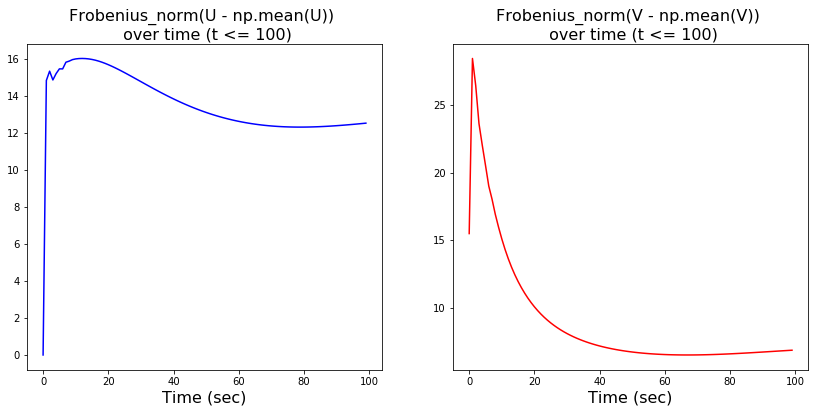

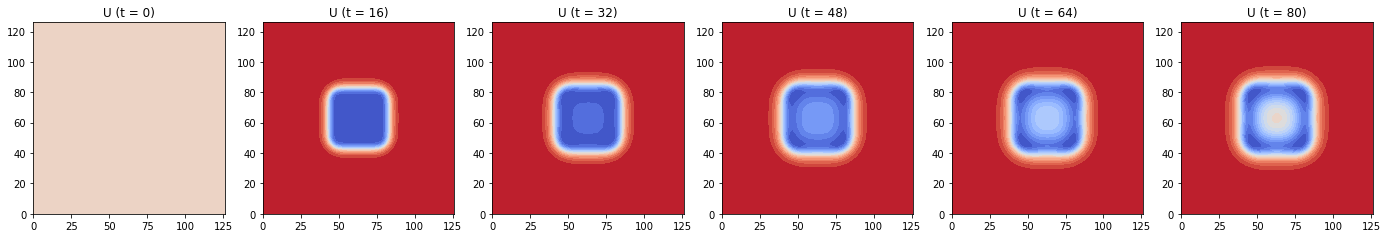

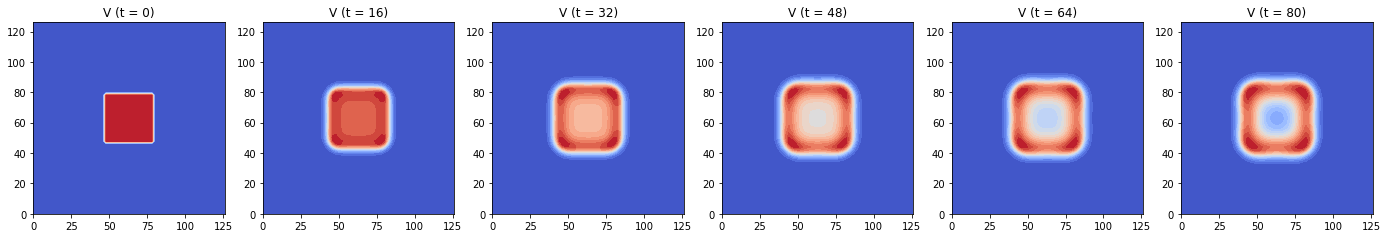

In [9]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 100, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=100, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=100, Nout=6)

## Crank Nicolson Method

dt = 1, time_steps = 10000
elapsed_clock_time = 40.75575304031372


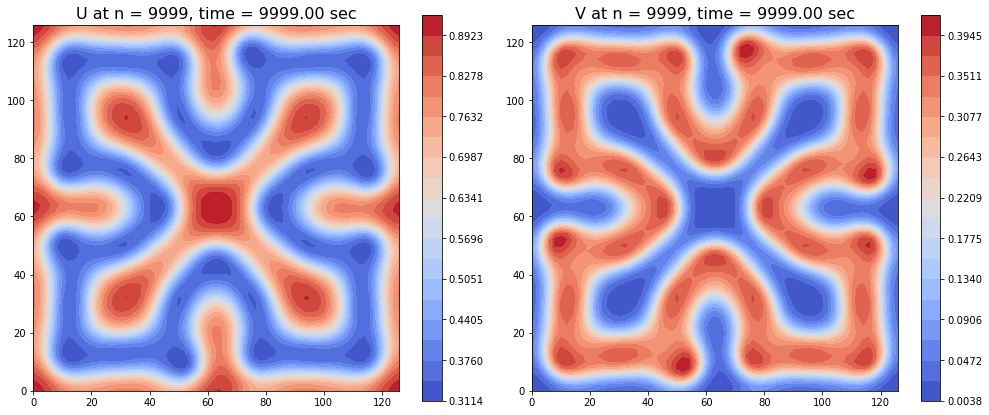

In [10]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Construct the transform matrix of U and V
# L = Laplace_matrix(Ny, Nx)
L = Laplace_matrix_sparse(Ny, Nx)
Tu = sparse.eye(N) - 0.5 * Du * c * L
Tv = sparse.eye(N) - 0.5 * Dv * c * L

# Factorize Tu, Tv
solve_Tu = linalg.factorized(Tu.tocsc())
solve_Tv = linalg.factorized(Tv.tocsc())

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))


# Start timer
start = time.time()

# CN Method
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U1d[i - 1]-np.mean(U1d[i - 1])))
    V_norm_arr[i-1] = np.linalg.norm((V1d[i - 1]-np.mean(V1d[i - 1])))
    time_range[i-1] = (i-1) * dt
    
    bU = (0.5 * Du * c) * L.dot(U1d[i - 1]) \
        + np.multiply((1 - dt * np.square(V1d[i - 1]) - dt * ff), U1d[i - 1]) + dt * ff
    U1d[i] = solve_Tu(bU)

    bV = (0.5 * Dv * c) * L.dot(V1d[i - 1]) + (1 - dt * kk - dt * ff) * V1d[i - 1] \
        + dt * np.multiply(U1d[i - 1], np.square(V1d[i - 1]))
    V1d[i] = solve_Tv(bV)

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U1d[-1]-np.mean(U1d[-1])))
V_norm_arr[-1] = np.linalg.norm((V1d[-1]-np.mean(V1d[-1])))
time_range[-1] = (time_steps-1) * dt

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

plot_pattern(U2d, V2d, time_steps - 1, time_steps - 1, h, dt)

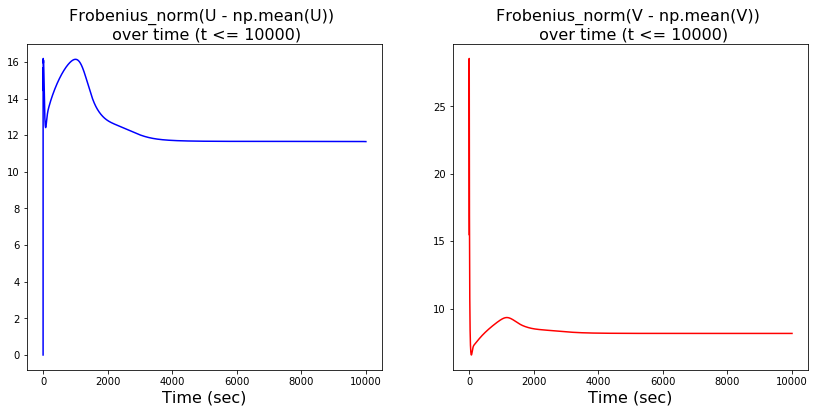

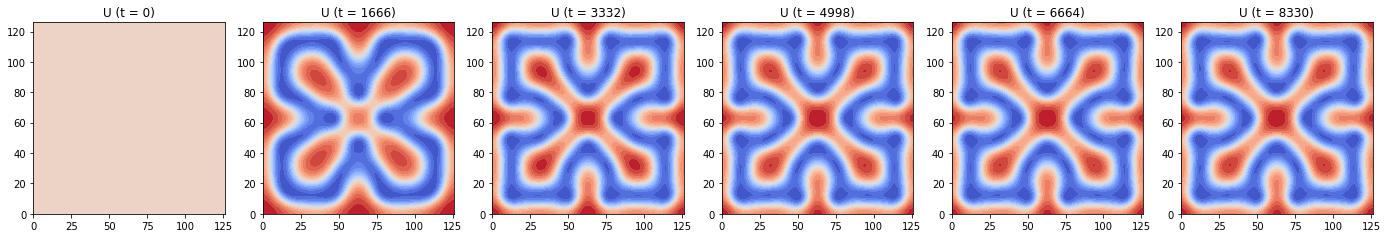

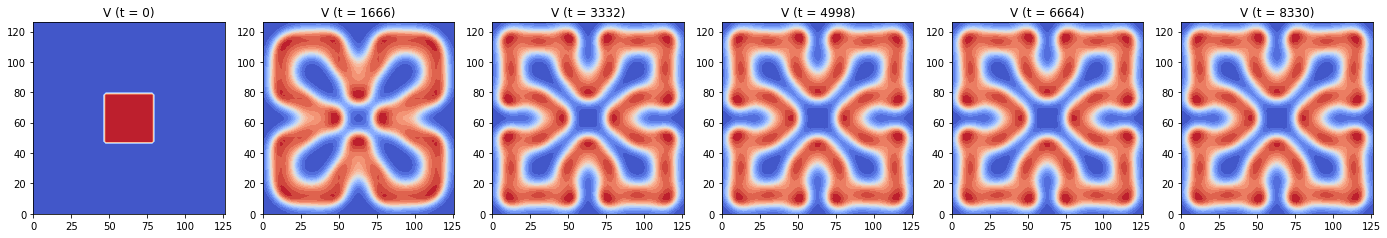

In [11]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=1, Nout=6)

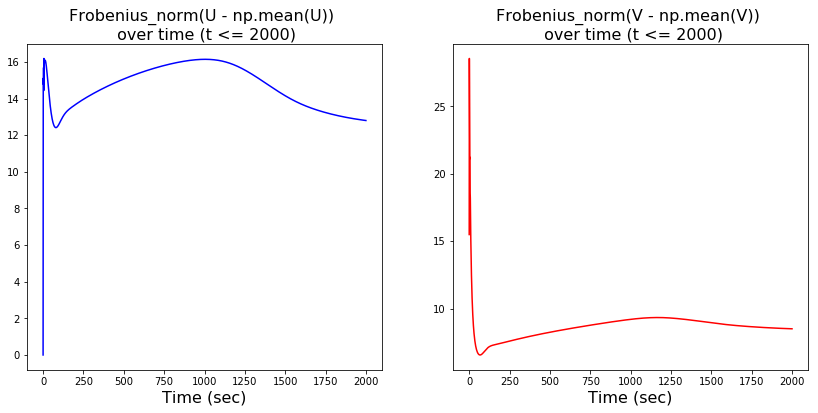

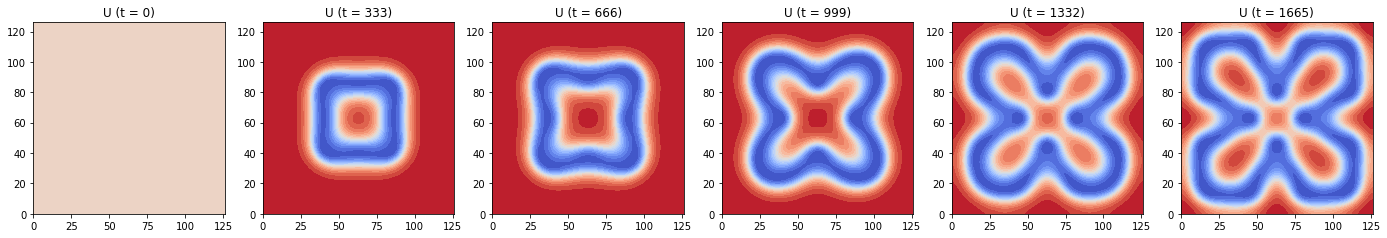

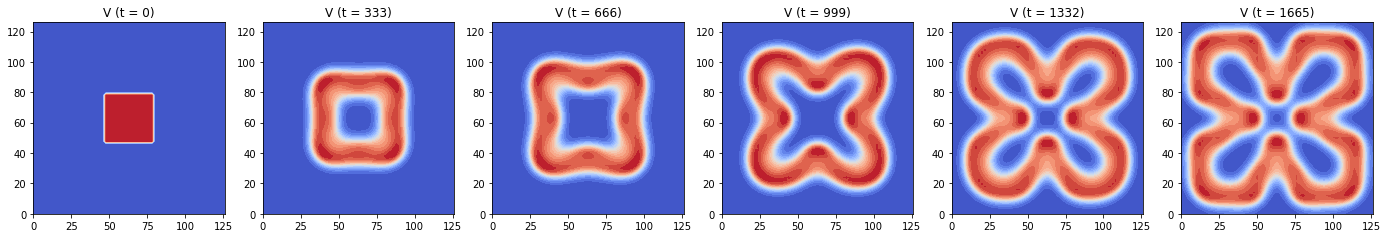

In [12]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 5, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=5, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=5, Nout=6)

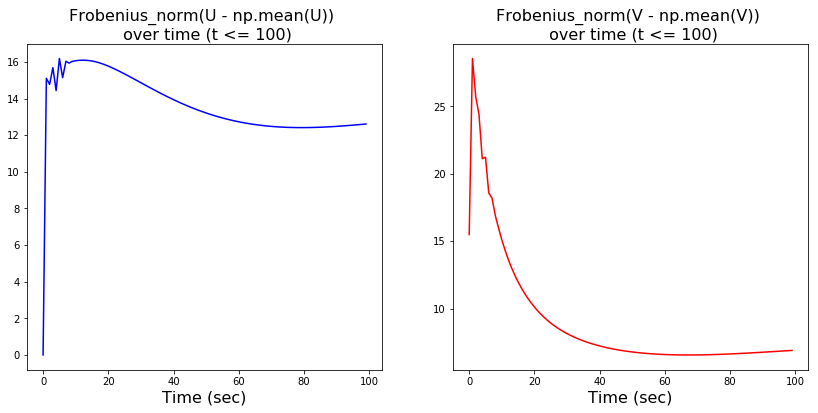

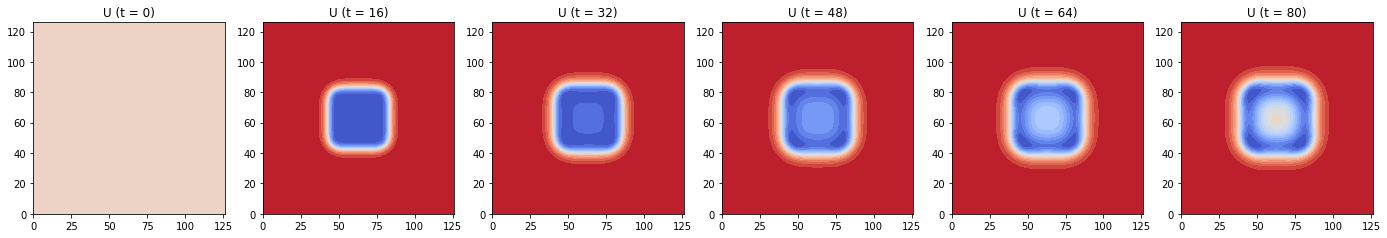

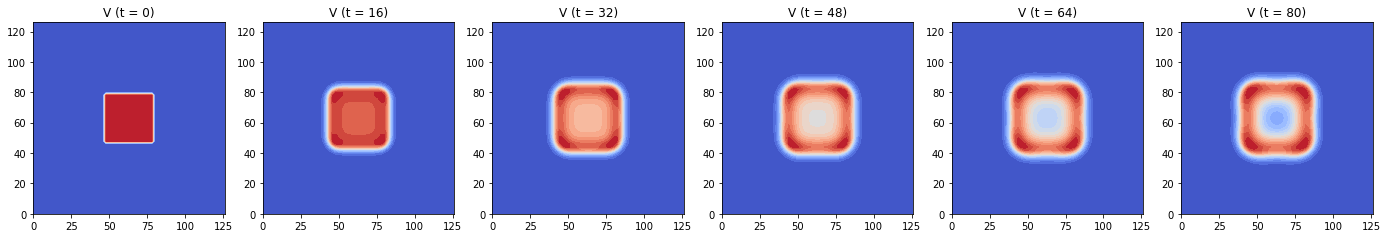

In [13]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 100, time_steps, end_t)

plot_pattern_evolution(U2d, h, dt, time_steps, name='U', r=100, Nout=6)
plot_pattern_evolution(V2d, h, dt, time_steps, name='V', r=100, Nout=6)

## Alternating Direction Implicit Method

dt = 1.5, time_steps = 6666
elapsed_clock_time = 11.599159955978394


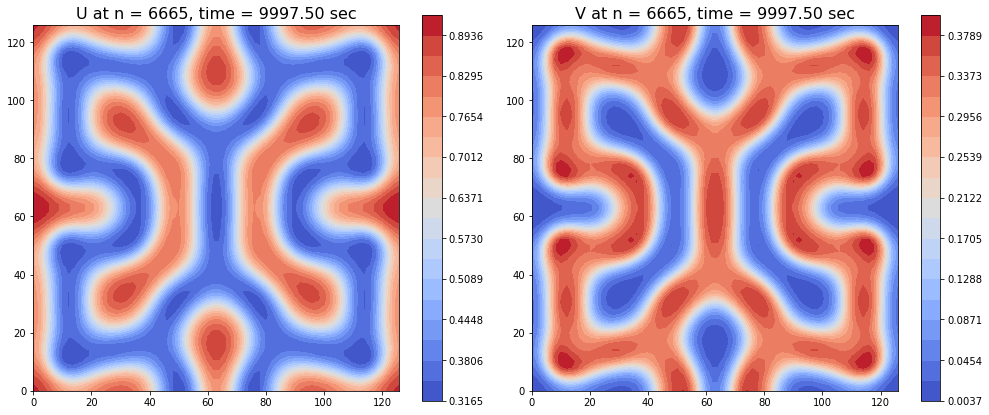

In [14]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
print('dt = {}, time_steps = {}'.format(dt, time_steps))
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

U_norm_arr = np.zeros((time_steps,))
V_norm_arr = np.zeros((time_steps,))
time_range = np.zeros((time_steps,))


# Start timer
start = time.time()

# Generate pattern
for i in range(1, time_steps):
    U_norm_arr[i-1] = np.linalg.norm((U[i - 1]-np.mean(U[i - 1])), ord='fro')
    V_norm_arr[i-1] = np.linalg.norm((V[i - 1]-np.mean(V[i - 1])), ord='fro')
    time_range[i-1] = (i-1) * dt
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
        + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) \
        + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

print('elapsed_clock_time = %s' % (time.time() - start))

U_norm_arr[-1] = np.linalg.norm((U[-1]-np.mean(U[-1])), ord='fro')
V_norm_arr[-1] = np.linalg.norm((V[-1]-np.mean(V[-1])), ord='fro')
time_range[-1] = (time_steps-1) * dt

plot_pattern(U, V, time_steps-1, time_steps-1, h, dt, filled=True)

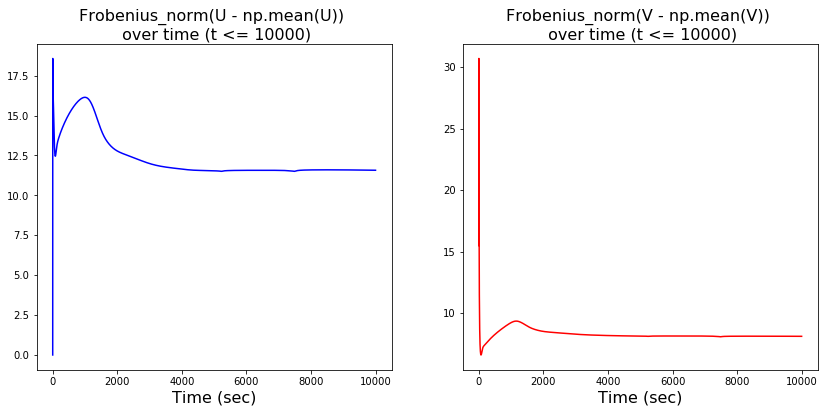

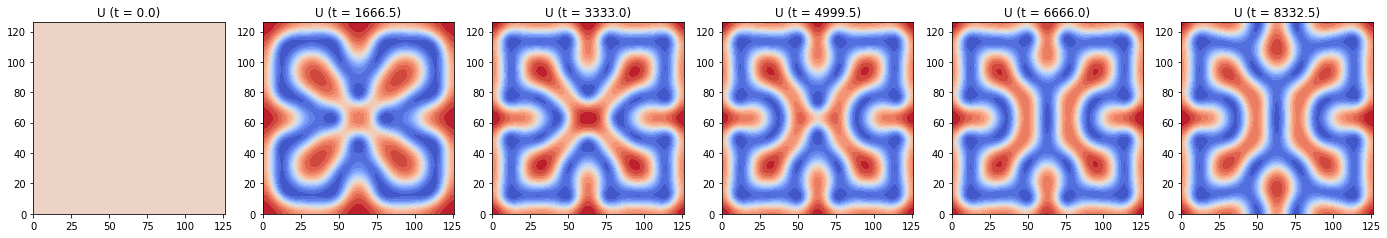

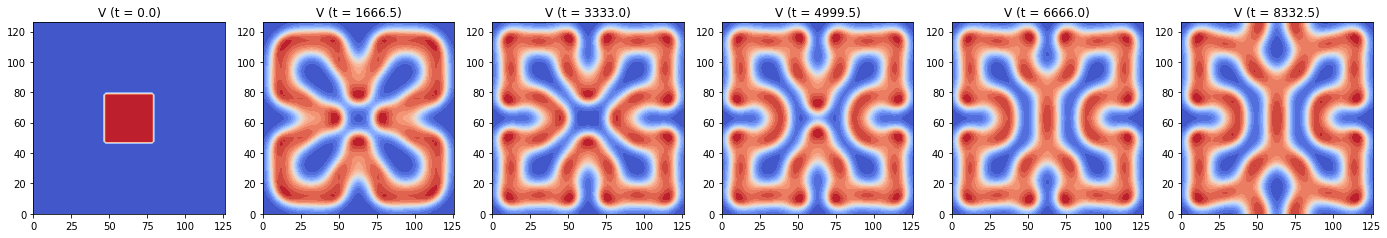

In [15]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 1, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)

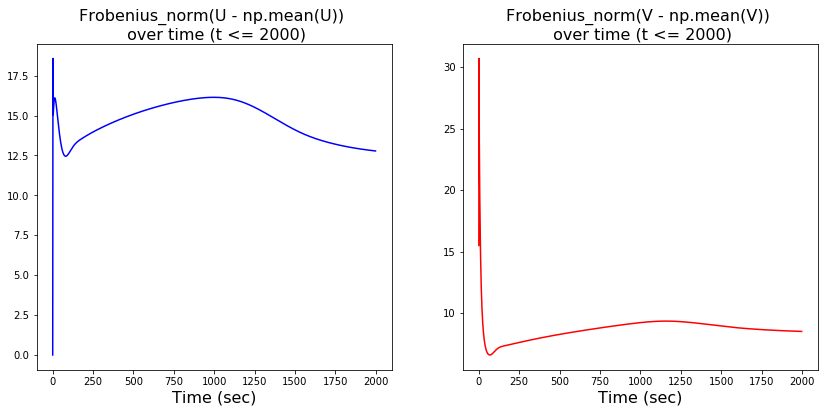

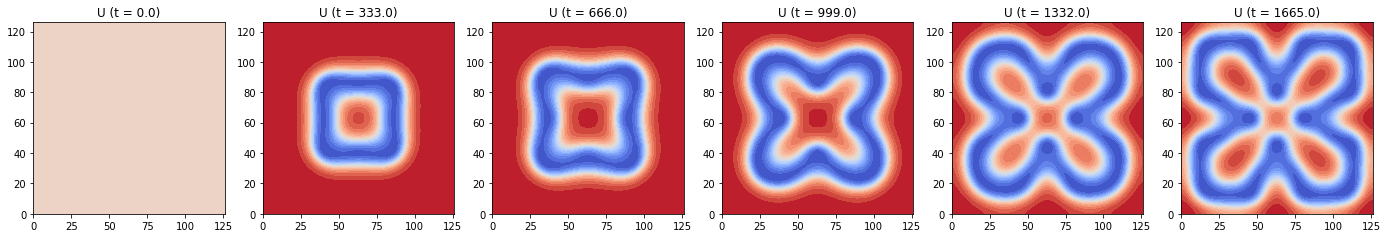

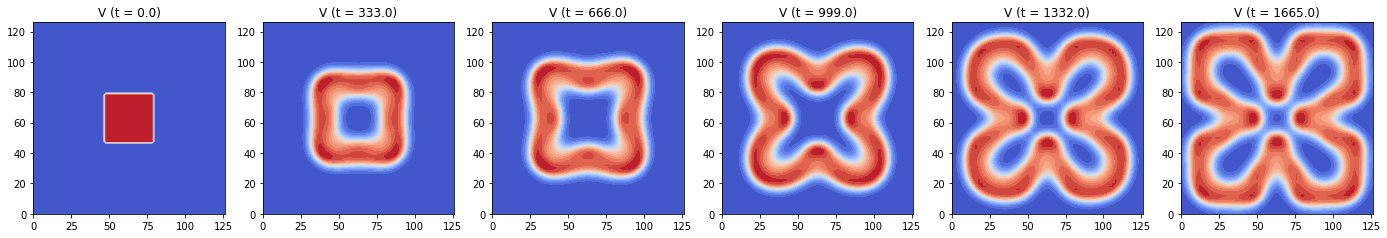

In [16]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 5, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=5, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=5, Nout=6)

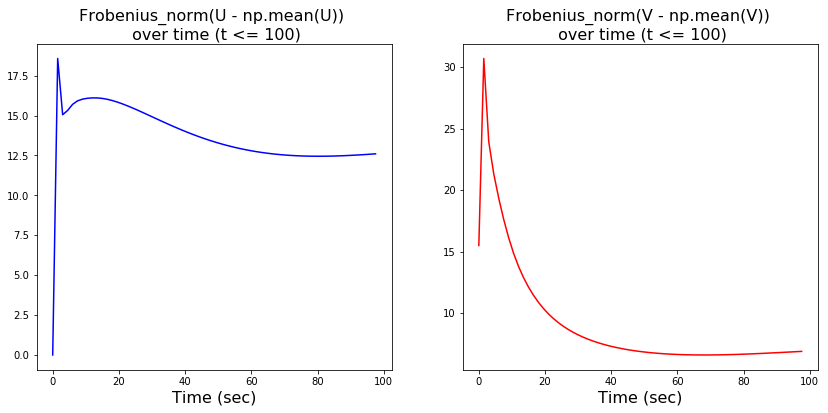

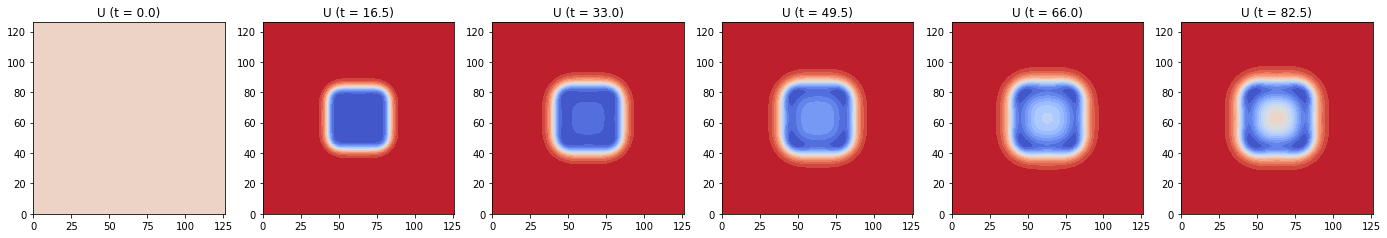

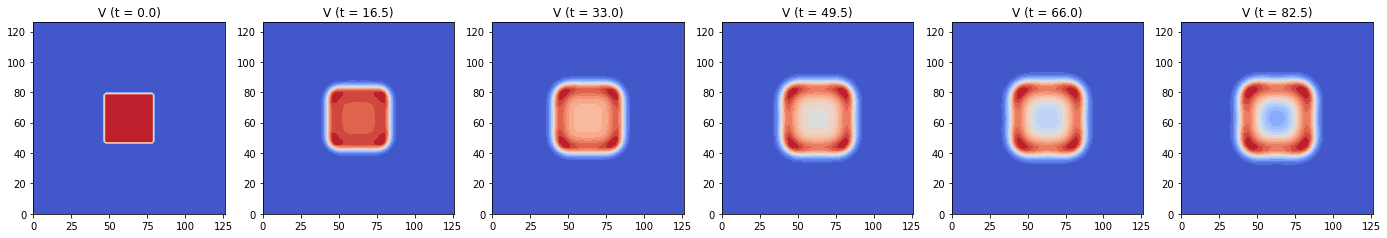

In [17]:
plot_norm_evolution(time_range, U_norm_arr, V_norm_arr, 100, time_steps, end_t)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=100, Nout=6)
plot_pattern_evolution(V, h, dt, time_steps, name='V', r=100, Nout=6)

## Summary

### Pattern Formation Analysis
We used each method to compute the solution pattern matrix, printed its runtime, plotted the pattern at the ending state, and also showed the evolution of the mean deducted Frobenius norm of U and V. We found that for the **GS** model, the patterns' evolution over time and ending states solved by Forward Euler, Backward Euler and Crank Nicolson method are similar but different from the results given by the ADI method. Inspecting the evolution of patterns, we see the ending states given by Forward Euler, Backward Euler and Crank Nicolson method appeared at earlier time in the evolution process with ADI method. This suggests that numerical methods with different orders of accuracy applied to the same PDE model could lead to different solutions. 

Judging from the evolution of the mean deducted Frobenius norm of the U and V matrices, the norm firstly grows and peaks before t=10(s). The norm entered a stable phase after t=100(s) and almost stayed the same after t=2000(s). Thus, we also plotted the evolution of the patterns before t=100(s) and t=2000(s) to gain a more detailed sense of the pattern's formation process. 

### Numerical Stability and Runtime Analysis
The explicit Forward Euler method is expected to have the smallest limit for time step size ($dt \leq \frac{h^2}{4 \text{max}(D_u, D_v)}$), while the other 3 partially implicit (implicit for diffusion term and explicit for reaction terms) methods are expected to have larger limit for dt. We **numerically checked the limit of time step size (dt)** for each method. The results are summarized in the following table. The results matched our expectation. Similar to the GM model, the explicit Foward Euler method has the most rigorous limit for dt (max(dt)=0.9), the other three implicit methods allow dt to be larger (max(dt)>=1.3). As we used comparable time step size (dt $\sim$ 1) among all methods, the runtimes of the explicit Forward Euler is shorter than any other implicit method. We expect the runtime of the ADI method to be the shortest among all implicit methods since it solves a smaller matrix of tridiagonal form. The actual runtimes matched our expectation. Since here, we solve a 64 X 64 grid with the ADI method using dt = 1.5 and a 4096 X 4096 grid with the Backward Euler and Crank Nicolson method using dt = 1, ADI runs much faster than Backward Euler or Crank Nicolson method.


|        Method       |  Runtime  | Stability limit for dt | 
|---------------------|-----------|------------------------|
| Forward Euler       |   8.467   |     0.9                |
| Backward Euler      |  41.290   |     1.3                |
| Crank Nicolson      |  40.756   |     1.3                |
| ADI method          |  11.599   |     1.7                |
